In this notebook I do the preprocessing and area weighting in Python, and then calculate the covariance matrix and the SVD in Fortran, using F2py wrapper functions. The results *SHOULD* be identical to the standalone Fortran program, assuming that the area weighting is the same (which is not the case??).

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import scipy
from glob import glob
import cartopy.crs as ccrs

%matplotlib inline

#import svd_nr
import svdlib

In [2]:
# SVD decomposition wrapper
print( svdlib.svdcmp.__doc__)

svdcmp(a,m,n,w,v,[mp,np])

Wrapper for ``svdcmp``.

Parameters
----------
a : input rank-2 array('f') with bounds (mp,np)
m : input int
n : input int
w : input rank-1 array('f') with bounds (np)
v : input rank-2 array('f') with bounds (np,np)

Other Parameters
----------------
mp : input int, optional
    Default: shape(a,0)
np : input int, optional
    Default: shape(a,1)



In [3]:
# Covariance matrix wrapper
print( svdlib.covar.__doc__)

covar(dat1,dat2,a,[nx1,ny1,nxy1,nx2,ny2,nxy2,nt])

Wrapper for ``covar``.

Parameters
----------
dat1 : input rank-3 array('f') with bounds (nx1,ny1,nt)
dat2 : input rank-3 array('f') with bounds (nx2,ny2,nt)
a : input rank-2 array('f') with bounds (nxy1,nxy2)

Other Parameters
----------------
nx1 : input int, optional
    Default: shape(dat1,0)
ny1 : input int, optional
    Default: shape(dat1,1)
nxy1 : input int, optional
    Default: shape(a,0)
nx2 : input int, optional
    Default: shape(dat2,0)
ny2 : input int, optional
    Default: shape(dat2,1)
nxy2 : input int, optional
    Default: shape(a,1)
nt : input int, optional
    Default: shape(dat1,2)



# Prepare input data

In [4]:
sst_filename = '/Users/leo/workspace/data/ERSST/v3b/netcdf/sst_all.nc'
ds_sst = xr.open_dataset(sst_filename)
ds_sst = ds_sst.squeeze('lev') # remove singleton dimension
ds_sst_tropical = ds_sst.sel(lat=slice(-20.,20), time=slice('1979','2011'))

# ERA INTERIM 200 HPA GEOPOTENTIAL HEIGHT
REANALYSIS = "ERA-I"
h250_filename = '/Users/leo/workspace/data/ERA-Interim/geopotential_flt_1979-2012.nc'
ds_h250_global = xr.open_dataset(h250_filename)

ds_h250 = ds_h250_global.sel(latitude=slice(88.5,0), time=slice('1979','2011'))
ds_h250['lat']=ds_h250['latitude']
ds_h250['lon']=ds_h250['longitude']

In [5]:
sst_ANN = ds_sst_tropical['sst'].groupby(ds_sst_tropical['time.year']).mean(dim='time')
sst_ANN_diff = sst_ANN - sst_ANN.mean(axis=0) # anomalies

(nt, nx, ny) = sst_ANN.shape
sst_ANN_flat = sst_ANN_diff.values.reshape(nt,nx*ny)
#sst_ANN_flat.shape

# no SST over land, these result in NaNs we need to filter out
mynan = np.isnan(sst_ANN_flat[0,:])
#mynan.shape

sst_ANN_flat_nonan = sst_ANN_flat[:,~mynan]
sst_ANN_flat_nonan.shape

(33, 2951)

In [6]:
# area weighting
def cosdeg(ar):
    """ Cosine in degrees"""
    return np.cos(np.deg2rad(ar))

def sindeg(ar):
    """ sine in degrees"""
    return np.sin(np.deg2rad(ar))

lon2d, lat2d = np.meshgrid(ds_h250.variables['lon'], ds_h250.variables['lat'])
lat2d = lat2d[::2,::2] # resampling

#lat2d_flat = lat2d.reshape(nx2*ny2)
#lat2d_flat_nt = np.tile(lat2d_flat,1).reshape(1,nx2*ny2)
#w2 = np.sqrt(cosdeg(lat2d_flat_nt))

w2 = np.sqrt(cosdeg(lat2d))
print('w2 shape',w2.shape, 'min=', w2.min())
print('weights', w2[:,0])


# Preparing Z200 anomalies
h250_ANN = ds_h250['Z200'].groupby(ds_h250['time.year']).mean(dim='time')
h250_ANN_diff = h250_ANN - h250_ANN.mean(axis=0) # anomalies
h250_ANN_diff = h250_ANN_diff[:,::2,::2] # resampling

(nt2, nx2, ny2) = h250_ANN_diff.shape
print('dimensions', nx2,ny2)

# Apply weights
h250_ANN_diff *= w2

h250_ANN_flat = h250_ANN_diff.values.reshape(nt2,nx2*ny2)

# 0.5 degree resolution gives long array 
h250_ANN_flat.shape

w2 shape (60, 240) min= 0.161792917978
weights [ 0.16179292  0.22877053  0.28010551  0.32330862  0.36128409  0.39551797
  0.42689053  0.45597334  0.48316184  0.50874261  0.5329309   0.55589297
  0.57776021  0.59863841  0.61861412  0.63775908  0.65613344  0.67378817
  0.69076679  0.70710678  0.72284062  0.73799664  0.75259965  0.76667154
  0.78023165  0.79329716  0.8058834   0.81800404  0.82967137  0.84089642
  0.85168913  0.86205848  0.87201259  0.88155882  0.89070385  0.89945372
  0.90781396  0.91578959  0.92338517  0.93060486  0.93745246  0.94393142
  0.95004489  0.95579572  0.96118652  0.96621966  0.97089726  0.97522127
  0.97919341  0.98281526  0.98608819  0.98901345  0.99159211  0.99382511
  0.99571324  0.99725719  0.99845748  0.99931453  0.99982865  1.        ]
dimensions 60 240


(33, 14400)

(60, 240)


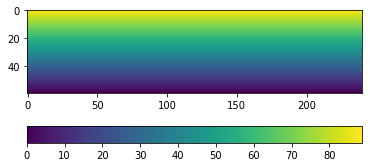

In [7]:
print(lat2d.shape)
plt.imshow(lat2d)
plt.colorbar(orientation='horizontal')

(60, 240)


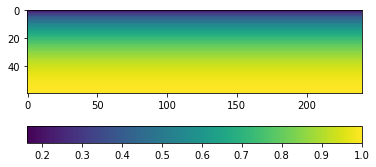

In [8]:
print(w2.shape)
plt.imshow(w2)
plt.colorbar(orientation='horizontal')

# Calling Fortran SVD routine

## Covariance matrix

In [9]:
"""
covar(dat1,dat2,a,[nx1,ny1,nxy1,nx2,ny2,nxy2,nt])

Parameters
----------
dat1 : input rank-3 array('f') with bounds (nx1,ny1,nt)
dat2 : input rank-3 array('f') with bounds (nx2,ny2,nt)
a : input rank-2 array('f') with bounds (nxy1,nxy2)

Other Parameters
----------------
nx1 : input int, optional
    Default: shape(dat1,0)
ny1 : input int, optional
    Default: shape(dat1,1)
nxy1 : input int, optional
    Default: shape(a,0)
nx2 : input int, optional
    Default: shape(dat2,0)
ny2 : input int, optional
    Default: shape(dat2,1)
nxy2 : input int, optional
    Default: shape(a,1)
nt : input int, optional
    Default: shape(dat1,2)
""" 

dat1 = h250_ANN_diff.values.transpose((2,1,0))
dat1 = dat1.astype(np.float32, order='F')

print('dat1 shape', dat1.shape)

nx1 = dat1.shape[0]
ny1 = dat1.shape[1]
nt  = dat1.shape[2]
nxy1 = nx1 * ny1

dat2 = sst_ANN_flat_nonan.transpose((1,0))
dat2 = dat2[:,np.newaxis,:]
dat2 = dat2.astype(np.float32, order='F')
print('dat2 shape', dat2.shape)

nx2 = dat2.shape[0]
ny2 = dat2.shape[1]
nt2 = dat2.shape[2]
nxy2 = nx2*ny2

assert nt==nt2, 'nt = %d, nt2 = %d' %(nt,nt2)

dat1 shape (240, 60, 33)
dat2 shape (2951, 1, 33)


In [10]:
A = np.empty((nxy1,nxy2),order='F',dtype=np.float32)

In [11]:
np.isfortran(dat1), np.isfortran(dat2), np.isfortran(A)

(True, True, True)

In [12]:
dat1.dtype, dat2.dtype, A.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [13]:
#svdlib.covar(dat1,dat2,A,nx1,ny1,nxy1,nx2,ny2,nxy2,nt1)
svdlib.covar(dat1,dat2,A)

## compute SVD

In [14]:
"""
svdcmp(a,m,n,w,v,[mp,np])

Wrapper for ``svdcmp``.

Parameters
----------
a : input rank-2 array('f') with bounds (mp,np)
m : input int
n : input int
w : input rank-1 array('f') with bounds (np)
v : input rank-2 array('f') with bounds (np,np)

Other Parameters
----------------
mp : input int, optional
    Default: shape(a,0)
np : input int, optional
    Default: shape(a,1)

"""
s = np.empty((nxy2), dtype=np.float32, order='F')
V = np.empty((nxy2,nxy2), dtype=np.float32, order='F')

In [21]:
U = A.copy(order='F') # keep covariance matrix A
U.dtype

dtype('float32')

In [22]:
# Calculate SVD (takes a long time!! )
svdlib.svdcmp(U,nxy1,nxy2,s,V)

In [31]:
U.shape, s.shape, V.shape

((14400, 2951), (2951,), (2951, 2951))

# Analysis

In [32]:
A_reconstructed = np.dot(np.dot(U,np.diag(s)), V.T)
np.linalg.norm(A-A_reconstructed)

0.038985491

In [33]:
scf = s**2./np.sum(s**2.)
print(scf[:3])

[ 0.51722455  0.42107764  0.02924085]


In [42]:
imode = 1 # select mode number

# Convert 1d arrays to spatial patterns
# Display modal information
mc_sst = np.ma.masked_array(np.zeros(sst_ANN_flat.shape[1])) # no time dimension
mc_sst[~mynan] = - V[:,imode] # sign is arbitrary
mc_sst[mynan] = np.ma.masked
mc_sst = mc_sst.reshape(nx,ny) #* stt_ANN[0,:,:] # multiply with anomalies
print(mc_sst.shape)

# convert to DataArray to facilitate further processing
mc_sst_da = xr.DataArray(mc_sst, coords=[ds_sst_tropical['lat'], ds_sst_tropical['lon']], dims=['lat', 'lon'])

(21, 180)


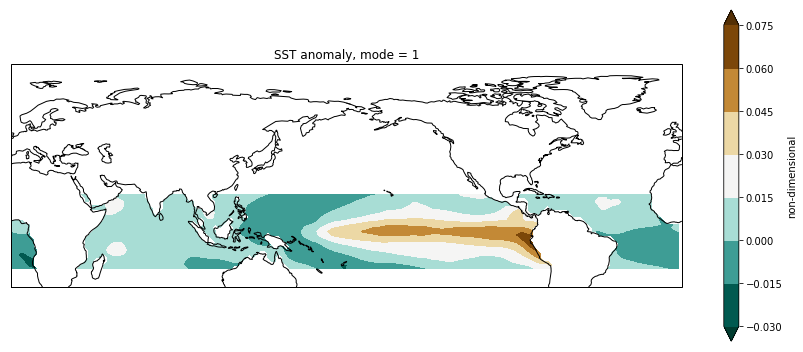

In [43]:
myproj = ccrs.PlateCarree()
myproj2 = ccrs.PlateCarree(central_longitude = -180.)
fig, axes = plt.subplots(1, figsize=(12,5),subplot_kw={'projection': myproj2})
cmap='BrBG_r'

def plot_mode_sst(ds, ax):    
    lon2d, lat2d = np.meshgrid(ds['lon'], ds['lat'])
    absmax = np.abs(ds).max().values
    levs = [-1,-0.7,-0.4,-0.1,0.1,0.4,0.7,1]
    levs = [-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4]
#    levs = np.linspace(-absmax, absmax, 11)
    
    cf = ax.contourf(lon2d, lat2d, ds.values, 
        transform = myproj, 
                     #levels=levs,
        cmap=cmap, extend='both')
    
    ax.coastlines()
    ax.set_global()
    ax.set_ylim(-30,90)

    ax.set_title('SST anomaly, mode = %d' % imode)
    cb = fig.colorbar(cf, ax=ax, label="non-dimensional")
    fig.tight_layout()
    #ax.set_extent([1, 360, -30, 90], myproj)
    
ax = axes
plot_mode_sst(mc_sst_da, ax)